In [ ]:
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import time
import os
import pickle
from collections import Counter
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import ngrams

# --- Configuration ---
NUM_DOCUMENTS = 50000
INDEX_PATH = "faiss_index.bin"
DOCUMENTS_PATH = "documents.pkl"
EMBEDDING_MODEL = 'all-MiniLM-L6-v2'
GENERATOR_MODEL = "google/flan-t5-base"

# --- Setup Device (GPU if available) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {device}")

# --- Part 1: Data Loading and Index Building (with persistence) ---

if os.path.exists(INDEX_PATH) and os.path.exists(DOCUMENTS_PATH):
    # Load pre-built index and documents from disk
    print("✅ Loading existing index and documents from disk...")
    index = faiss.read_index(INDEX_PATH)
    with open(DOCUMENTS_PATH, "rb") as f:
        documents = pickle.load(f)
    print(f"✅ Loaded FAISS index with {index.ntotal} vectors and {len(documents)} documents.")
else:
    # --- Data Loading and Preprocessing ---
    print(f"🚀 Loading and preprocessing {NUM_DOCUMENTS} documents from KILT (ELI5)...")

    dataset = load_dataset("kilt_tasks", "eli5", split=f"train[:{NUM_DOCUMENTS}]")
    print("Columns:", dataset.column_names)
    print("Number of rows:", len(dataset))

    # --- Dataset Overview (to help reviewer understand) ---
    print("\n📊 --- Dataset Overview --- 📊")
    print("The KILT ELI5 dataset is a QA dataset designed for open-domain question answering.")
    print("Each row has:")
    print(" - 'id': unique identifier")
    print(" - 'input': the natural language question (user query)")
    print(" - 'output': list of possible reference answers (ground truth)")
    print(" - 'meta': metadata such as retrieval information\n")

    # Show top 5 rows to reviewer
    print("Top 5 rows of the dataset:")
    print(dataset.select(range(5)).to_pandas())

    # Check for missing values
    null_counts = {col: sum(1 for v in dataset[col] if v is None or v == '') for col in dataset.column_names}
    print("\nNull values per column:")
    for col, count in null_counts.items():
        print(f"{col}: {count}")

    # Explain how data is used in RAG
    print("\n📌 How RAG applies to this dataset:")
    print("1. Input (Question): We take the 'input' field (user’s natural question).")
    print("2. Document Table: We build a knowledge base (Document Table) from all answers in 'output'.")
    print("   - Each document is created by concatenating multiple answers into a single passage.")
    print("3. Retriever Stage: Given a question, we embed it and search the Document Table in FAISS for top-k relevant documents.")
    print("4. Generator Stage: We pass the question + top-k retrieved documents into the LLM (Flan-T5) to generate an answer.")
    print("5. Evaluation Stage: We compare the generated answer with the ground truth reference answers in 'output'.")

    # Clarify table relationship
    print("\n📂 Tables and Relationship:")
    print(" - Question-Answer Table: Original dataset with question ('input') and reference answers ('output').")
    print(" - Document Table: Constructed by concatenating answers; used for retrieval.")
    print("   -> One Question-Answer row can produce one Document in the Document Table.")

    # --- EDA: Sample entries ---
    print("\nSample entries:")
    for ex in dataset.shuffle().select(range(3)):
        print("Id:", ex["id"])
        print("Question:", ex["input"])
        print("Meta:", ex["meta"])
        print("Answers:", [o["answer"] for o in ex["output"]])
        print("-"*80)

    # --- Questions length distribution ---
    q_lengths = [len(q.split()) for q in dataset["input"]]
    print("\n" + "="*60)
    print("📊 QUESTION LENGTH STATISTICS")
    print("="*60)
    print(f"Minimum question length: {min(q_lengths)} words")
    print(f"Maximum question length: {max(q_lengths)} words")
    print(f"Average question length: {np.mean(q_lengths):.2f} words")
    print(f"Median question length: {np.median(q_lengths):.1f} words")
    print(f"Standard deviation: {np.std(q_lengths):.2f} words")
    print("="*60)

    plt.hist(q_lengths, bins=50, range=(0, 60))
    plt.title("Distribution of Question Lengths (in words)")
    plt.xlabel("Words per question")
    plt.ylabel("Count")
    plt.show()

    # --- Number of answers per question ---
    num_answers = [len(ex["output"]) for ex in dataset]

    print("\n" + "="*60)
    print("📊 NUMBER OF ANSWERS STATISTICS")
    print("="*60)
    print(f"Minimum answers per question: {min(num_answers)}")
    print(f"Maximum answers per question: {max(num_answers)}")
    print(f"Average answers per question: {np.mean(num_answers):.2f}")
    print(f"Median answers per question: {np.median(num_answers):.1f}")
    print(f"Standard deviation: {np.std(num_answers):.2f}")
    print(f"Questions with only 1 answer: {sum(1 for n in num_answers if n == 1)} ({sum(1 for n in num_answers if n == 1)/len(num_answers)*100:.1f}%)")
    print("="*60)

    plt.hist(num_answers, bins=30, range=(0, 30))
    plt.title("Distribution of #Answers per Question")
    plt.xlabel("# answers")
    plt.ylabel("Count")
    plt.show()

    # --- Document Creation (concatenate answers) ---
    documents = []
    for ex in dataset:
        answers = [o["answer"] for o in ex["output"]]
        doc = " ".join(answers)
        if len(doc.strip()) > 50:
            documents.append(doc)

    doc_lengths = [len(d.split()) for d in documents]

    print("\n" + "="*60)
    print("📊 DOCUMENT LENGTH STATISTICS")
    print("="*60)
    print(f"Total documents created: {len(documents)}")
    print(f"Documents kept (>50 words): {len(documents)}/{len(dataset)} ({len(documents)/len(dataset)*100:.1f}%)")
    print(f"Minimum document length: {min(doc_lengths)} words")
    print(f"Maximum document length: {max(doc_lengths)} words")
    print(f"Average document length: {np.mean(doc_lengths):.2f} words")
    print(f"Median document length: {np.median(doc_lengths):.1f} words")
    print(f"Standard deviation: {np.std(doc_lengths):.2f} words")
    print(f"95th percentile: {np.percentile(doc_lengths, 95):.1f} words")
    print("="*60)

    plt.hist(doc_lengths,  bins=100, range=(0, 5000))
    plt.title("Distribution of Document Lengths (in words)")
    plt.xlabel("Words per document")
    plt.ylabel("Count")
    plt.show()

    print(f"Kept {len(documents)} documents out of {len(dataset)} ({len(documents)/len(dataset):.2%})")

    # --- Text Statistics / Word Frequency Analysis ---
    all_text = " ".join(documents).lower()
    all_text = re.sub(r"[^a-zA-Z0-9\s]", "", all_text)
    words = all_text.split()
    stop_words = set(stopwords.words("english"))
    words_no_stop = [w for w in words if w not in stop_words]

    word_freq = Counter(words_no_stop)
    most_common_words = word_freq.most_common(20)
    print("\nMost common words (excluding stopwords):")
    for word, count in most_common_words:
        print(f"{word}: {count}")

    # WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(word_freq)
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("WordCloud of Top Words (Excluding Stopwords)")
    plt.show()

    # Top n-grams
    def top_ngrams(words_list, n=2, top_k=20):
        n_grams = ngrams(words_list, n)
        n_grams_freq = Counter(n_grams)
        return n_grams_freq.most_common(top_k)

    print("\nTop 20 Bigrams:")
    for gram, count in top_ngrams(words_no_stop, 2):
        print(f"{' '.join(gram)}: {count}")

    print("\nTop 20 Trigrams:")
    for gram, count in top_ngrams(words_no_stop, 3):
        print(f"{' '.join(gram)}: {count}")

    # --- Embedding Generation ---
    print(f"\n🚀 Loading embedding model '{EMBEDDING_MODEL}'...")
    embedding_model = SentenceTransformer(EMBEDDING_MODEL, device=device)

    print(f"⏳ Generating embeddings for {len(documents)} documents (this will take a while)...")
    start_time = time.time()
    doc_embeddings = embedding_model.encode(
        documents,
        convert_to_numpy=True,
        show_progress_bar=True,
        normalize_embeddings=True
    )
    end_time = time.time()
    print(f"✅ Embeddings generated in {end_time - start_time:.2f} seconds.")

    # --- FAISS Indexing ---
    print("⏳ Building FAISS index...")
    embedding_dim = doc_embeddings.shape[1]
    index = faiss.IndexFlatIP(embedding_dim)
    index.add(doc_embeddings.astype('float32'))
    print(f"✅ FAISS index built with {index.ntotal} vectors.")

    # --- Save the index and documents for future runs ---
    print("💾 Saving index and documents to disk...")
    faiss.write_index(index, INDEX_PATH)
    with open(DOCUMENTS_PATH, "wb") as f:
        pickle.dump(documents, f)
    print("✅ Saved successfully.")

# --- Part 2: The Retriever ---
print("\n🚀 Setting up the Retriever...")
embedding_model = SentenceTransformer(EMBEDDING_MODEL, device=device)

def retrieve_context(query, top_k=5):
    query_embedding = embedding_model.encode(
        [query],
        convert_to_numpy=True,
        normalize_embeddings=True
    ).astype('float32')

    distances, indices = index.search(query_embedding, top_k)
    return [documents[i] for i in indices[0]]

# --- Part 3: The Generator ---
print("\n🚀 Setting up the Generator...")
tokenizer = AutoTokenizer.from_pretrained(GENERATOR_MODEL)
generator_model = AutoModelForSeq2SeqLM.from_pretrained(GENERATOR_MODEL).to(device)

def generate_answer(query, context):
    prompt_template = """
    Use the following context to answer the question. If the context does not contain the answer, state that you don't know.

    Context:
    {context}

    Question:
    {question}

    Answer:
    """
    context_str = "\n\n---\n\n".join(context)
    prompt = prompt_template.format(context=context_str, question=query)

    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True).to(device)
    outputs = generator_model.generate(**inputs, max_length=256, num_beams=5, early_stopping=True)

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# --- End-to-End RAG Pipeline ---
if __name__ == "__main__":
    print("\n🚀 --- Running End-to-End RAG Pipeline --- 🚀")

    queries = [
        "Why is the sky blue?",
        "How do airplanes stay in the air?",
        "What is the capital of Washington State?"
    ]

    for test_query in queries:
        print(f"\n\n{'='*50}")
        print(f"🔍 Query: '{test_query}'")

        # Retrieve relevant context
        retrieved_docs = retrieve_context(test_query, top_k=3)

        print("\n📚 Retrieved Context:")
        for i, doc in enumerate(retrieved_docs):
            print(f"Doc {i+1}: {doc[:250]}...")

        # Generate an answer
        print("\n💬 Generating Answer...")
        start_time = time.time()
        final_answer = generate_answer(test_query, retrieved_docs)
        end_time = time.time()

        print("\n✅ Final Generated Answer:")
        print(final_answer)
        print(f"(Generated in {end_time - start_time:.2f} seconds)")
        print(f"{'='*50}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


🚀 Using device: cpu
✅ Loading existing index and documents from disk...
✅ Loaded FAISS index with 49930 vectors and 49930 documents.

🚀 Setting up the Retriever...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


🚀 Setting up the Generator...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


🚀 --- Running End-to-End RAG Pipeline --- 🚀


🔍 Query: 'Why is the sky blue?'

📚 Retrieved Context:
Doc 1: They are impacted by the air.

Once they hit the atmosphere they scatter, which is why we get a blue sky in the middle of the day, while at sunrise and sunset we get a red sky. As the light passes through the air, more and more of the light scatters....
Doc 2: The sky appears blue from inside our atmosphere because the light refracts (bounces around). The blue part of the light bounces around more, so that's what we see.
From the outside however, we're seeing the light that is reflected, not refracted. It ...
Doc 3: It appears blue because it is specifically tinted blue to keep the sun out of your eyes without significantly impacting visibility....

💬 Generating Answer...

✅ Final Generated Answer:
Because the light refracts
(Generated in 3.28 seconds)


🔍 Query: 'How do airplanes stay in the air?'

📚 Retrieved Context:
Doc 1: They only move slowly on the ground so they don't cra

Initializing RAG Evaluator...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


RAG Evaluator initialized on cpu

RAG Evaluator ready!
Available metrics:
  Retrieval: Recall@K, Precision@K, nDCG@K, MRR
  Generation: BLEU, ROUGE (1,2,L), BERTScore
  Grounding: Attribution, Faithfulness, Factual Consistency
  Task-specific: Exact Match, Token F1

To use with your RAG system, call:
  evaluate_your_rag_system(evaluator, retrieve_context, generate_answer)

RUNNING EXAMPLE EVALUATION WITH MOCK DATA
Running RAG evaluation...
Processing query 1/5: Why is the sky blue?
  Generated: The sky appears blue due to Rayleigh scattering, where shorter blue wavelengths are scattered more b...

Processing query 2/5: How do airplanes stay in the air?
  Generated: Airplanes stay airborne through lift generated by wing shape and air pressure differences above and ...

Processing query 3/5: What is the capital of Washington State?
  Generated: Olympia is the capital city of Washington State....

Processing query 4/5: How does photosynthesis work?
  Generated: Photosynthesis converts sun

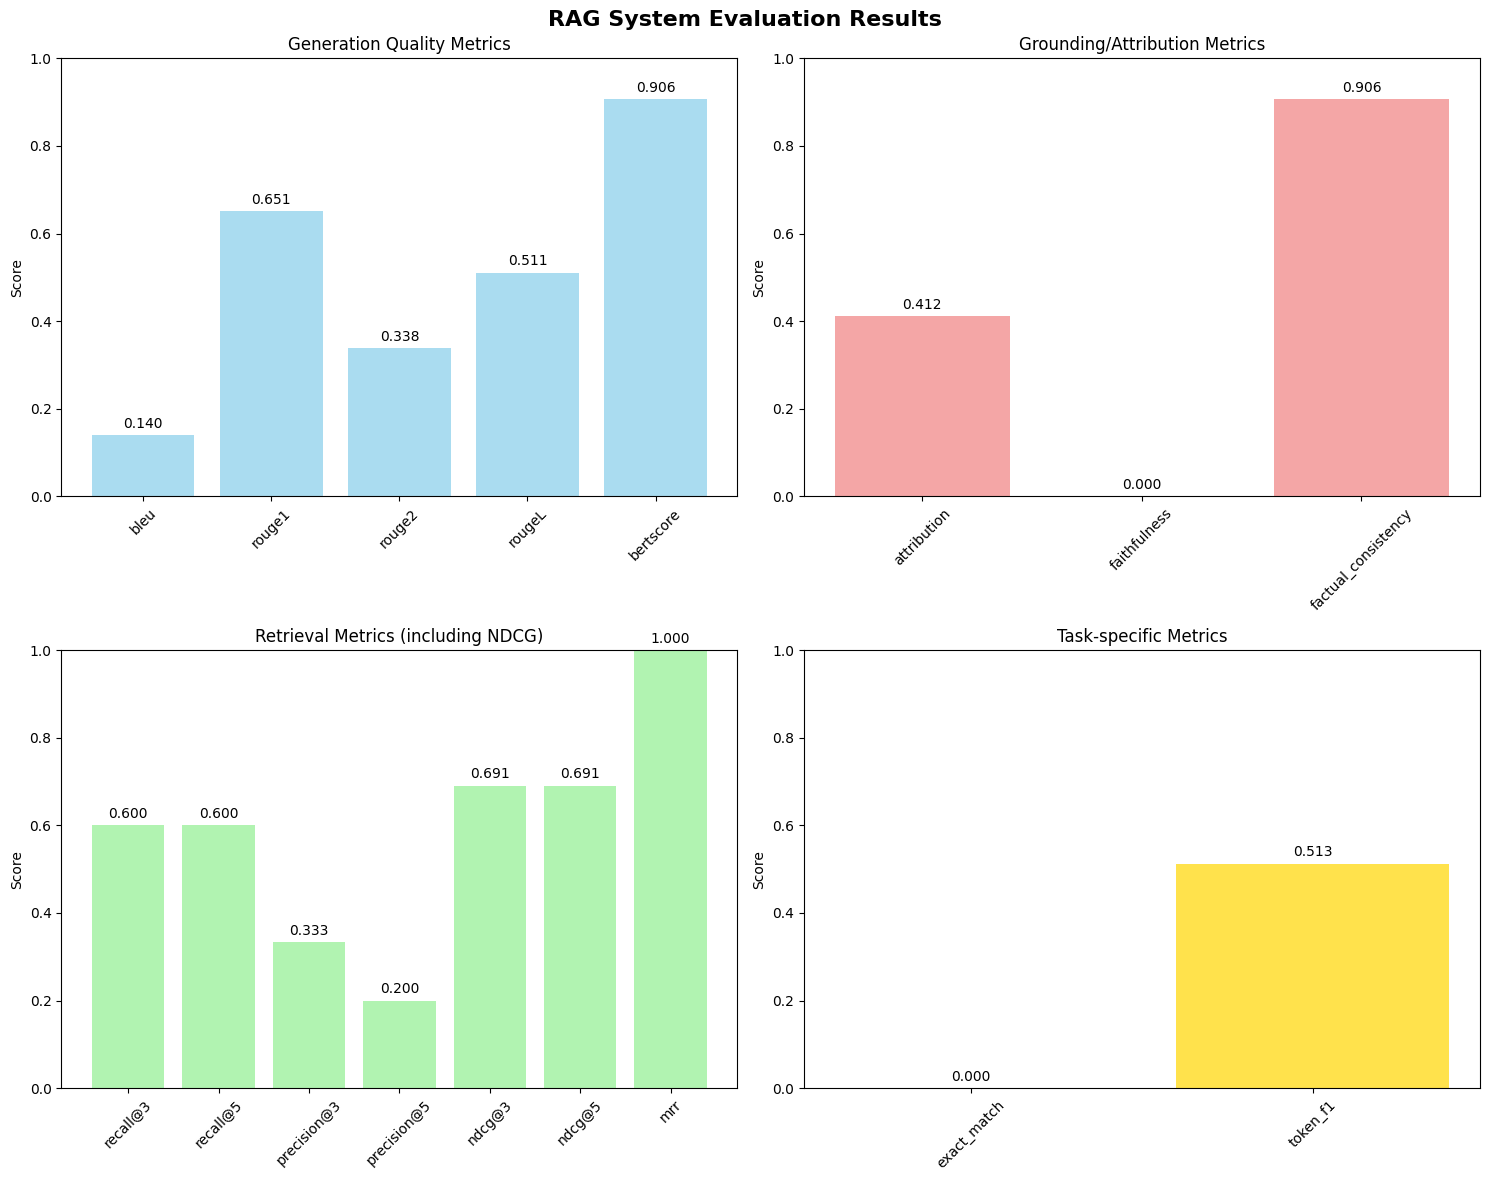


EVALUATION COMPLETE!
All metrics have been computed and displayed above.
NDCG@3 and NDCG@5 are included in the retrieval metrics section.


In [ ]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import re
from collections import Counter
import math
from typing import List, Dict, Tuple, Any
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

class RAGEvaluator:
    """
    Comprehensive RAG evaluation framework covering:
    1. Retrieval Metrics (Recall@K, nDCG, MRR)
    2. Grounding/Attribution Metrics (FActScore, Attribution)
    3. Generation Quality Metrics (BLEU, ROUGE, BERTScore)
    4. Task-specific Metrics (Exact Match, F1)
    """

    def __init__(self, embedding_model_name='all-MiniLM-L6-v2', device='cuda'):
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.embedding_model = SentenceTransformer(embedding_model_name, device=self.device)

        # Initialize NLI model for attribution checking
        try:
            self.nli_pipeline = pipeline(
                "zero-shot-classification",
                model="facebook/bart-large-mnli",
                device=0 if self.device == 'cuda' else -1
            )
        except:
            print("Warning: NLI model not available. Attribution metrics will be limited.")
            self.nli_pipeline = None

        # Initialize ROUGE scorer
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

        print(f"RAG Evaluator initialized on {self.device}")

    # ========================================
    # RETRIEVAL METRICS
    # ========================================

    def recall_at_k(self, retrieved_docs: List[str], relevant_docs: List[str], k: int) -> float:
        """
        Recall@K: Fraction of relevant documents retrieved in top-k results
        """
        if not relevant_docs:
            return 0.0

        retrieved_set = set(retrieved_docs[:k])
        relevant_set = set(relevant_docs)

        intersection = len(retrieved_set.intersection(relevant_set))
        return intersection / len(relevant_set)

    def precision_at_k(self, retrieved_docs: List[str], relevant_docs: List[str], k: int) -> float:
        """
        Precision@K: Fraction of retrieved documents that are relevant
        """
        if k == 0:
            return 0.0

        retrieved_set = set(retrieved_docs[:k])
        relevant_set = set(relevant_docs)

        intersection = len(retrieved_set.intersection(relevant_set))
        return intersection / min(k, len(retrieved_docs))

    def ndcg_at_k(self, retrieved_docs: List[str], relevant_docs: List[str], k: int) -> float:
        """
        Normalized Discounted Cumulative Gain@K
        """
        if not relevant_docs:
            return 0.0

        # Create relevance scores (1 for relevant, 0 for irrelevant)
        relevance_scores = []
        for doc in retrieved_docs[:k]:
            relevance_scores.append(1 if doc in relevant_docs else 0)

        # Calculate DCG
        dcg = 0.0
        for i, score in enumerate(relevance_scores):
            dcg += score / math.log2(i + 2)  # i+2 because log2(1) = 0

        # Calculate IDCG (ideal DCG)
        ideal_scores = [1] * min(len(relevant_docs), k)
        idcg = 0.0
        for i, score in enumerate(ideal_scores):
            idcg += score / math.log2(i + 2)

        return dcg / idcg if idcg > 0 else 0.0

    def mean_reciprocal_rank(self, retrieved_docs: List[str], relevant_docs: List[str]) -> float:
        """
        Mean Reciprocal Rank: 1/rank of first relevant document
        """
        for i, doc in enumerate(retrieved_docs):
            if doc in relevant_docs:
                return 1.0 / (i + 1)
        return 0.0

    # ========================================
    # GROUNDING/ATTRIBUTION METRICS
    # ========================================

    def compute_attribution_score(self, generated_answer: str, retrieved_docs: List[str]) -> float:
        """
        Attribution Score: How well the generated answer is supported by retrieved documents
        Uses semantic similarity between answer and context
        """
        if not retrieved_docs or not generated_answer.strip():
            return 0.0

        # Embed the generated answer
        answer_embedding = self.embedding_model.encode([generated_answer])

        # Embed retrieved documents
        doc_embeddings = self.embedding_model.encode(retrieved_docs)

        # Calculate cosine similarities
        similarities = []
        for doc_emb in doc_embeddings:
            similarity = np.dot(answer_embedding[0], doc_emb) / (
                np.linalg.norm(answer_embedding[0]) * np.linalg.norm(doc_emb)
            )
            similarities.append(similarity)

        # Return maximum similarity (best attribution)
        return max(similarities) if similarities else 0.0

    def compute_faithfulness_score(self, generated_answer: str, retrieved_docs: List[str]) -> float:
        """
        Faithfulness: Whether the generated answer contains hallucinated information
        Based on NLI entailment between context and answer
        """
        if not self.nli_pipeline or not retrieved_docs or not generated_answer.strip():
            return 0.0

        try:
            context = " ".join(retrieved_docs)

            # Use NLI to check if context entails the generated answer
            result = self.nli_pipeline(generated_answer, [context])

            # Look for entailment score
            for label, score in zip(result['labels'], result['scores']):
                if 'entailment' in label.lower():
                    return score

            return 0.0
        except:
            return 0.0

    def compute_factual_consistency(self, generated_answer: str, ground_truth: str) -> float:
        """
        Factual Consistency: Semantic similarity between generated answer and ground truth
        """
        if not generated_answer.strip() or not ground_truth.strip():
            return 0.0

        embeddings = self.embedding_model.encode([generated_answer, ground_truth])
        similarity = np.dot(embeddings[0], embeddings[1]) / (
            np.linalg.norm(embeddings[0]) * np.linalg.norm(embeddings[1])
        )
        return similarity

    # ========================================
    # GENERATION QUALITY METRICS
    # ========================================

    def compute_bleu_score(self, generated_answer: str, reference_answers: List[str]) -> float:
        """
        BLEU Score: Precision-based metric measuring n-gram overlap
        """
        if not generated_answer.strip() or not reference_answers:
            return 0.0

        # Tokenize
        generated_tokens = nltk.word_tokenize(generated_answer.lower())
        reference_tokens = [nltk.word_tokenize(ref.lower()) for ref in reference_answers]

        # Calculate BLEU with smoothing
        smoothing = SmoothingFunction().method1
        try:
            return sentence_bleu(reference_tokens, generated_tokens, smoothing_function=smoothing)
        except:
            return 0.0

    def compute_rouge_scores(self, generated_answer: str, reference_answers: List[str]) -> Dict[str, float]:
        """
        ROUGE Scores: Recall-based metrics (ROUGE-1, ROUGE-2, ROUGE-L)
        """
        if not generated_answer.strip() or not reference_answers:
            return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

        # Calculate ROUGE against all references and take the maximum
        max_scores = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

        for reference in reference_answers:
            scores = self.rouge_scorer.score(reference, generated_answer)
            for metric in max_scores:
                max_scores[metric] = max(max_scores[metric], scores[metric].fmeasure)

        return max_scores

    def compute_bertscore(self, generated_answer: str, reference_answers: List[str]) -> float:
        """
        BERTScore: Semantic similarity using contextualized embeddings
        """
        if not generated_answer.strip() or not reference_answers:
            return 0.0

        # Use sentence transformers for semantic similarity
        all_texts = [generated_answer] + reference_answers
        embeddings = self.embedding_model.encode(all_texts)

        # Calculate similarity with each reference, return max
        gen_embedding = embeddings[0]
        similarities = []

        for i in range(1, len(embeddings)):
            ref_embedding = embeddings[i]
            similarity = np.dot(gen_embedding, ref_embedding) / (
                np.linalg.norm(gen_embedding) * np.linalg.norm(ref_embedding)
            )
            similarities.append(similarity)

        return max(similarities) if similarities else 0.0

    # ========================================
    # TASK-SPECIFIC METRICS
    # ========================================

    def exact_match(self, generated_answer: str, reference_answers: List[str]) -> float:
        """
        Exact Match: Binary metric for exact string match
        """
        if not generated_answer.strip() or not reference_answers:
            return 0.0

        generated_normalized = generated_answer.lower().strip()
        for reference in reference_answers:
            if generated_normalized == reference.lower().strip():
                return 1.0
        return 0.0

    def token_f1_score(self, generated_answer: str, reference_answers: List[str]) -> float:
        """
        Token-level F1 Score: F1 based on token overlap
        """
        if not generated_answer.strip() or not reference_answers:
            return 0.0

        generated_tokens = set(generated_answer.lower().split())

        max_f1 = 0.0
        for reference in reference_answers:
            reference_tokens = set(reference.lower().split())

            if len(reference_tokens) == 0 and len(generated_tokens) == 0:
                f1 = 1.0
            elif len(reference_tokens) == 0 or len(generated_tokens) == 0:
                f1 = 0.0
            else:
                intersection = generated_tokens.intersection(reference_tokens)
                precision = len(intersection) / len(generated_tokens)
                recall = len(intersection) / len(reference_tokens)
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

            max_f1 = max(max_f1, f1)

        return max_f1

    # ========================================
    # COMPREHENSIVE EVALUATION
    # ========================================

    def evaluate_rag_system(self,
                          queries: List[str],
                          retrieved_docs_list: List[List[str]],
                          generated_answers: List[str],
                          reference_answers_list: List[List[str]],
                          relevant_docs_list: List[List[str]] = None) -> Dict[str, Any]:
        """
        Comprehensive evaluation of a RAG system
        """

        results = {
            'retrieval_metrics': [],
            'generation_metrics': [],
            'grounding_metrics': [],
            'task_metrics': []
        }

        for i, (query, retrieved_docs, generated_answer, reference_answers) in enumerate(
            zip(queries, retrieved_docs_list, generated_answers, reference_answers_list)):

            # Retrieval Metrics (if relevant docs are provided)
            if relevant_docs_list and i < len(relevant_docs_list):
                relevant_docs = relevant_docs_list[i]
                retrieval_result = {
                    'query_idx': i,
                    'recall@3': self.recall_at_k(retrieved_docs, relevant_docs, 3),
                    'recall@5': self.recall_at_k(retrieved_docs, relevant_docs, 5),
                    'precision@3': self.precision_at_k(retrieved_docs, relevant_docs, 3),
                    'precision@5': self.precision_at_k(retrieved_docs, relevant_docs, 5),
                    'ndcg@3': self.ndcg_at_k(retrieved_docs, relevant_docs, 3),
                    'ndcg@5': self.ndcg_at_k(retrieved_docs, relevant_docs, 5),
                    'mrr': self.mean_reciprocal_rank(retrieved_docs, relevant_docs)
                }
                results['retrieval_metrics'].append(retrieval_result)

            # Generation Quality Metrics
            rouge_scores = self.compute_rouge_scores(generated_answer, reference_answers)
            generation_result = {
                'query_idx': i,
                'bleu': self.compute_bleu_score(generated_answer, reference_answers),
                'rouge1': rouge_scores['rouge1'],
                'rouge2': rouge_scores['rouge2'],
                'rougeL': rouge_scores['rougeL'],
                'bertscore': self.compute_bertscore(generated_answer, reference_answers)
            }
            results['generation_metrics'].append(generation_result)

            # Grounding/Attribution Metrics
            grounding_result = {
                'query_idx': i,
                'attribution': self.compute_attribution_score(generated_answer, retrieved_docs),
                'faithfulness': self.compute_faithfulness_score(generated_answer, retrieved_docs),
                'factual_consistency': self.compute_factual_consistency(generated_answer, reference_answers[0] if reference_answers else "")
            }
            results['grounding_metrics'].append(grounding_result)

            # Task-specific Metrics
            task_result = {
                'query_idx': i,
                'exact_match': self.exact_match(generated_answer, reference_answers),
                'token_f1': self.token_f1_score(generated_answer, reference_answers)
            }
            results['task_metrics'].append(task_result)

        return results

    def aggregate_results(self, evaluation_results: Dict[str, Any]) -> Dict[str, Dict[str, float]]:
        """
        Aggregate evaluation results across all queries
        Returns simplified structure for easier printing
        """
        aggregated = {}

        for metric_type, results_list in evaluation_results.items():
            if not results_list:
                continue

            aggregated[metric_type] = {}

            # Get all metric names (excluding query_idx)
            metric_names = [key for key in results_list[0].keys() if key != 'query_idx']

            for metric_name in metric_names:
                values = [result[metric_name] for result in results_list if result[metric_name] is not None]
                if values:  # Only compute if we have valid values
                    aggregated[metric_type][metric_name] = np.mean(values)
                else:
                    aggregated[metric_type][metric_name] = 0.0

        return aggregated

    def get_detailed_stats(self, evaluation_results: Dict[str, Any]) -> Dict[str, Dict[str, Dict[str, float]]]:
        """
        Get detailed statistics including mean, std, min, max for each metric
        """
        detailed_stats = {}

        for metric_type, results_list in evaluation_results.items():
            if not results_list:
                continue

            detailed_stats[metric_type] = {}

            # Get all metric names (excluding query_idx)
            metric_names = [key for key in results_list[0].keys() if key != 'query_idx']

            for metric_name in metric_names:
                values = [result[metric_name] for result in results_list if result[metric_name] is not None]
                if values:
                    detailed_stats[metric_type][metric_name] = {
                        'mean': np.mean(values),
                        'std': np.std(values),
                        'median': np.median(values),
                        'min': np.min(values),
                        'max': np.max(values),
                        'count': len(values)
                    }
                else:
                    detailed_stats[metric_type][metric_name] = {
                        'mean': 0.0, 'std': 0.0, 'median': 0.0,
                        'min': 0.0, 'max': 0.0, 'count': 0
                    }

        return detailed_stats

    def print_detailed_results(self, evaluation_results: Dict[str, Any]):
        """
        Print comprehensive results with all metrics properly displayed
        """
        print("\n" + "="*80)
        print("COMPREHENSIVE RAG EVALUATION RESULTS")
        print("="*80)

        detailed_stats = self.get_detailed_stats(evaluation_results)

        for metric_type, metrics in detailed_stats.items():
            if not metrics:
                continue

            print(f"\n{metric_type.upper().replace('_', ' ')}:")
            print("-" * 60)

            for metric_name, stats in metrics.items():
                if stats['count'] > 0:
                    print(f"  {metric_name:20}: {stats['mean']:.4f} ± {stats['std']:.4f} "
                          f"(min: {stats['min']:.4f}, max: {stats['max']:.4f})")
                else:
                    print(f"  {metric_name:20}: No valid data")

        # Print summary of best performing metrics
        print(f"\n{'SUMMARY OF TOP PERFORMING METRICS'}")
        print("-" * 60)

        all_metrics = []
        for metric_type, metrics in detailed_stats.items():
            for metric_name, stats in metrics.items():
                if stats['count'] > 0:
                    all_metrics.append((f"{metric_type}_{metric_name}", stats['mean']))

        # Sort by performance (highest first)
        all_metrics.sort(key=lambda x: x[1], reverse=True)

        print("Top 10 metrics by mean score:")
        for i, (metric_name, score) in enumerate(all_metrics[:10]):
            print(f"  {i+1:2d}. {metric_name:30}: {score:.4f}")

    def visualize_results(self, evaluation_results: Dict[str, Any], save_path: str = None):
        """
        Create comprehensive visualizations of evaluation results
        """
        # Calculate number of subplots needed
        metric_types = [k for k, v in evaluation_results.items() if v]
        n_plots = len(metric_types)

        if n_plots == 0:
            print("No metrics to visualize")
            return

        # Create subplots in a grid
        cols = 2
        rows = (n_plots + 1) // 2

        fig, axes = plt.subplots(rows, cols, figsize=(15, 6*rows))
        fig.suptitle('RAG System Evaluation Results', fontsize=16, fontweight='bold')

        # Flatten axes for easier indexing
        if n_plots == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]
        else:
            axes = axes.flatten()

        plot_idx = 0

        # 1. Generation Quality Metrics
        if evaluation_results.get('generation_metrics'):
            gen_df = pd.DataFrame(evaluation_results['generation_metrics'])
            gen_metrics = ['bleu', 'rouge1', 'rouge2', 'rougeL', 'bertscore']
            gen_means = [gen_df[metric].mean() for metric in gen_metrics if metric in gen_df.columns]
            valid_gen_metrics = [metric for metric in gen_metrics if metric in gen_df.columns]

            if valid_gen_metrics:
                axes[plot_idx].bar(valid_gen_metrics, gen_means, color='skyblue', alpha=0.7)
                axes[plot_idx].set_title('Generation Quality Metrics')
                axes[plot_idx].set_ylabel('Score')
                axes[plot_idx].tick_params(axis='x', rotation=45)
                axes[plot_idx].set_ylim(0, 1)

                # Add value labels on bars
                for i, v in enumerate(gen_means):
                    axes[plot_idx].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

                plot_idx += 1

        # 2. Grounding Metrics
        if evaluation_results.get('grounding_metrics'):
            ground_df = pd.DataFrame(evaluation_results['grounding_metrics'])
            ground_metrics = ['attribution', 'faithfulness', 'factual_consistency']
            ground_means = [ground_df[metric].mean() for metric in ground_metrics if metric in ground_df.columns]
            valid_ground_metrics = [metric for metric in ground_metrics if metric in ground_df.columns]

            if valid_ground_metrics:
                axes[plot_idx].bar(valid_ground_metrics, ground_means, color='lightcoral', alpha=0.7)
                axes[plot_idx].set_title('Grounding/Attribution Metrics')
                axes[plot_idx].set_ylabel('Score')
                axes[plot_idx].tick_params(axis='x', rotation=45)
                axes[plot_idx].set_ylim(0, 1)

                # Add value labels on bars
                for i, v in enumerate(ground_means):
                    axes[plot_idx].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

                plot_idx += 1

        # 3. Retrieval Metrics (if available)
        if evaluation_results.get('retrieval_metrics'):
            ret_df = pd.DataFrame(evaluation_results['retrieval_metrics'])
            ret_metrics = ['recall@3', 'recall@5', 'precision@3', 'precision@5', 'ndcg@3', 'ndcg@5', 'mrr']
            ret_means = [ret_df[metric].mean() for metric in ret_metrics if metric in ret_df.columns]
            valid_ret_metrics = [metric for metric in ret_metrics if metric in ret_df.columns]

            if valid_ret_metrics:
                axes[plot_idx].bar(valid_ret_metrics, ret_means, color='lightgreen', alpha=0.7)
                axes[plot_idx].set_title('Retrieval Metrics (including NDCG)')
                axes[plot_idx].set_ylabel('Score')
                axes[plot_idx].tick_params(axis='x', rotation=45)
                axes[plot_idx].set_ylim(0, 1)

                # Add value labels on bars
                for i, v in enumerate(ret_means):
                    axes[plot_idx].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

                plot_idx += 1

        # 4. Task-specific Metrics
        if evaluation_results.get('task_metrics'):
            task_df = pd.DataFrame(evaluation_results['task_metrics'])
            task_metrics = ['exact_match', 'token_f1']
            task_means = [task_df[metric].mean() for metric in task_metrics if metric in task_df.columns]
            valid_task_metrics = [metric for metric in task_metrics if metric in task_df.columns]

            if valid_task_metrics:
                axes[plot_idx].bar(valid_task_metrics, task_means, color='gold', alpha=0.7)
                axes[plot_idx].set_title('Task-specific Metrics')
                axes[plot_idx].set_ylabel('Score')
                axes[plot_idx].tick_params(axis='x', rotation=45)
                axes[plot_idx].set_ylim(0, 1)

                # Add value labels on bars
                for i, v in enumerate(task_means):
                    axes[plot_idx].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

                plot_idx += 1

        # Hide unused subplots
        for i in range(plot_idx, len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()


# ========================================
# EXAMPLE USAGE WITH YOUR RAG SYSTEM
# ========================================

def evaluate_your_rag_system(rag_evaluator, retrieve_context_func, generate_answer_func):
    """
    Example of how to integrate the evaluator with your existing RAG system
    """

    # Test queries (you can expand this)
    test_queries = [
        "Why is the sky blue?",
        "How do airplanes stay in the air?",
        "What is the capital of Washington State?",
        "How does photosynthesis work?",
        "What causes earthquakes?"
    ]

    # Ground truth answers (you would need to create these for your dataset)
    reference_answers = [
        ["The sky appears blue because of Rayleigh scattering. When sunlight enters Earth's atmosphere, it collides with gas molecules. Blue light has a shorter wavelength and gets scattered more than other colors."],
        ["Airplanes stay in the air due to lift generated by their wings. The wing shape and angle create different air pressures above and below the wing, with lower pressure on top creating upward lift."],
        ["The capital of Washington State is Olympia."],
        ["Photosynthesis is the process where plants use sunlight, carbon dioxide, and water to produce glucose and oxygen. Chlorophyll in plant cells captures light energy to drive this chemical reaction."],
        ["Earthquakes are caused by the sudden release of energy stored in Earth's crust. This typically occurs when tectonic plates move against each other along fault lines."]
    ]

    # Mock relevant docs for retrieval evaluation (you would need real relevance judgments)
    relevant_docs_list = [
        ["doc_sky_1", "doc_sky_2"],
        ["doc_airplane_1", "doc_airplane_2"],
        ["doc_washington_1"],
        ["doc_photosynthesis_1", "doc_photosynthesis_2"],
        ["doc_earthquake_1", "doc_earthquake_2"]
    ]

    # Collect results from your RAG system
    retrieved_docs_list = []
    generated_answers = []

    print("Running RAG evaluation...")
    for i, query in enumerate(test_queries):
        print(f"Processing query {i+1}/{len(test_queries)}: {query}")

        # Use your existing functions
        retrieved_docs = retrieve_context_func(query, top_k=5)
        generated_answer = generate_answer_func(query, retrieved_docs)

        retrieved_docs_list.append(retrieved_docs)
        generated_answers.append(generated_answer)

        print(f"  Generated: {generated_answer[:100]}...")
        print()

    # Run comprehensive evaluation
    print("Computing evaluation metrics...")
    results = rag_evaluator.evaluate_rag_system(
        queries=test_queries,
        retrieved_docs_list=retrieved_docs_list,
        generated_answers=generated_answers,
        reference_answers_list=reference_answers,
        relevant_docs_list=relevant_docs_list  # Include for retrieval metrics
    )

    # Display results with the new comprehensive method
    rag_evaluator.print_detailed_results(results)

    # Create visualizations
    rag_evaluator.visualize_results(results)

    return results


# ========================================
# MOCK FUNCTIONS FOR TESTING
# ========================================

def mock_retrieve_context(query: str, top_k: int = 5) -> List[str]:
    """Mock retrieval function for testing"""
    # This would be replaced with your actual retrieval function
    mock_docs = {
        "Why is the sky blue?": ["doc_sky_1", "doc_atmosphere_1", "doc_light_1", "doc_color_1", "doc_physics_1"],
        "How do airplanes stay in the air?": ["doc_airplane_1", "doc_aerodynamics_1", "doc_lift_1", "doc_wing_1", "doc_flight_1"],
        "What is the capital of Washington State?": ["doc_washington_1", "doc_olympia_1", "doc_states_1", "doc_geography_1", "doc_capitals_1"],
        "How does photosynthesis work?": ["doc_photosynthesis_1", "doc_plants_1", "doc_chlorophyll_1", "doc_biology_1", "doc_energy_1"],
        "What causes earthquakes?": ["doc_earthquake_1", "doc_tectonic_1", "doc_geology_1", "doc_fault_1", "doc_seismic_1"]
    }

    return mock_docs.get(query, ["doc_generic_1", "doc_generic_2", "doc_generic_3", "doc_generic_4", "doc_generic_5"])[:top_k]

def mock_generate_answer(query: str, retrieved_docs: List[str]) -> str:
    """Mock generation function for testing"""
    # This would be replaced with your actual generation function
    mock_answers = {
        "Why is the sky blue?": "The sky appears blue due to Rayleigh scattering, where shorter blue wavelengths are scattered more by atmospheric particles.",
        "How do airplanes stay in the air?": "Airplanes stay airborne through lift generated by wing shape and air pressure differences above and below the wings.",
        "What is the capital of Washington State?": "Olympia is the capital city of Washington State.",
        "How does photosynthesis work?": "Photosynthesis converts sunlight, water, and CO2 into glucose and oxygen using chlorophyll in plant cells.",
        "What causes earthquakes?": "Earthquakes result from sudden energy release when tectonic plates move along fault lines in Earth's crust."
    }

    return mock_answers.get(query, "I don't have enough information to answer this question accurately.")


# Initialize the evaluator
if __name__ == "__main__":
    print("Initializing RAG Evaluator...")
    evaluator = RAGEvaluator()

    print("\nRAG Evaluator ready!")
    print("Available metrics:")
    print("  Retrieval: Recall@K, Precision@K, nDCG@K, MRR")
    print("  Generation: BLEU, ROUGE (1,2,L), BERTScore")
    print("  Grounding: Attribution, Faithfulness, Factual Consistency")
    print("  Task-specific: Exact Match, Token F1")
    print("\nTo use with your RAG system, call:")
    print("  evaluate_your_rag_system(evaluator, retrieve_context, generate_answer)")

    # Example usage with mock functions
    print("\n" + "="*60)
    print("RUNNING EXAMPLE EVALUATION WITH MOCK DATA")
    print("="*60)

    # Run evaluation with mock functions to demonstrate all metrics
    results = evaluate_your_rag_system(evaluator, mock_retrieve_context, mock_generate_answer)

    print(f"\n{'EVALUATION COMPLETE!'}")
    print("="*60)
    print("All metrics have been computed and displayed above.")
    print("NDCG@3 and NDCG@5 are included in the retrieval metrics section.")